In [427]:
%load_ext rpy2.ipython
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import (LogisticRegression, LinearRegression, RidgeClassifier, Lasso, RandomizedLasso)
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score,ShuffleSplit,GridSearchCV,train_test_split
from sklearn.metrics import roc_auc_score,roc_curve, auc,confusion_matrix,classification_report,matthews_corrcoef
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer as DV
from tpot import TPOTClassifier


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Loading data

In [242]:
# load dataset and choose 'model'
path_dataset = "mdl_data.csv"
data=pd.read_csv(path_dataset)

choice=1
print('shape before: ',data.shape)
if (choice == 1):   # triage model
    data=data.iloc[:,0:41]   
elif (choice == 2): #after model
    data=data.iloc[:,list(range(0, 11))+list(range(41, 67))]
else: 
    #data = data[['study_id','death', 'evd_ct', 'age', 'temp_triage', 'headache_triage', 'hemorrhage_triage','diarrhea_triage','jaundice_triage','vomiting_triage','abdomnial_triage','asthenia_triage']]
    data = data[['study_id','death', 'evd_ct', 'disorientation_triage', 'jaundice_triage', 'headache_triage', 'days_admitted']]




shape before:  (575, 67)


# Helper functions

In [407]:

def repeatedCV (model, dataFeatures,dataOutcome):
    maxloop = 100
    splitsnb= 10
    testproportion =0.25
    
    results= []
    for k in range(maxloop):
        lecv = ShuffleSplit(n_splits=splitsnb, test_size= testproportion,random_state=1)
        results.append(cross_val_score(model, dataFeatures, dataOutcome, scoring='accuracy', cv=lecv))
    return results

def findOptimalHParametersThoughtCV (model,X,y, param_grid):
    scoringmethod='roc_auc'
    cvnb=10
    
    CV_LR = GridSearchCV(estimator=model,scoring=scoringmethod, param_grid=param_grid, cv= cvnb)
    CV_LR.fit(X, y)
    print('Best parameters from grid search' ,CV_LR.best_params_, ' , best score:', CV_LR.best_score_)
    return CV_LR


def evaluateModel (model,X_test,y_test):
    risk_threshold=0.5
    
    probs=  model.predict_proba(X_test)
    y_pred = [int(risk_threshold < p[1]) for p in probs]
    print("Accuracy: %0.2f " % (model.score(X_test, y_test)),'auc: ',roc_auc_score(y_test, y_pred))
    #print("Accuracy: %0.2f (+/- %0.2f)" % (model.score(X_test, y_test).mean(), model.score(X_test, y_test).std() * 2))
    print('Confusion Matrix\n',confusion_matrix(y_test,y_pred))
    print('Classification report\n',classification_report(y_test,y_pred))
    print('Matthew Correlation coefficient',matthews_corrcoef(y_test,y_pred))
    return y_pred,probs

def plotroc(y_test,pred,probs):
    fpr,tpr, _ = roc_curve(y_test,probs[:,1])
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

#  Preprocessing and feature engineering


In [400]:
#Preprocessing

################################ Poupulation selection #################
filtering = 0    # put to 1 to activate selection
locationFilter='va'
#######################################################################
# we remove all patients with missing evd_ct. 
#2 possible causes: {1. evd- (No ebola->no death prediction) (417 cases) 2. Unknown (14 cases)} 
data=data[np.isfinite(data['evd_ct'])]  # Dropping from 575 to 144!!


#data=data.dropna() # Dropping from 144 to 118
data=data.fillna(round(data.mean())) #Should round to not loose binary format of columns!
data = data.reset_index(drop=True) # so we have incremental indexes (dropped samples doesn't count anymore after this)



ytrue=data[['study_id','death']]
X=data.drop(['death','evd'],axis=1) #'study_id' could also be added to be droped

#the only columns wirh missing info: ,'malaria','referral_time',evd_ct' (removed higher),'quarantine'(removed by first two)
print('Missing values: \n' ,pd.isnull(X).values.any(), np.where(pd.isnull(X)))


ytrue = ytrue.set_index('study_id')
X = X.set_index('study_id')

print('shape after: ', X.shape)


###################  Adding features for population selection #######################
if (filtering == 1):
    X['location']= np.random.choice(['va','ge','ne','be','zu'], X.shape[0], p=[0.2,0.2,0.2,0.2,0.2])
    locationdict= pd.DataFrame(X['location']).to_dict(orient = 'records'  ) #In case, it is already included in database(extended version)
    vectorizer = DV( sparse = False )
    vec_tmp = vectorizer.fit_transform( locationdict)
    cities=[k.split('=')[1] for k in vectorizer.get_feature_names()]
    binarycities=pd.DataFrame(vec_tmp, columns=cities)
    binarycities=binarycities.set_index(X.index)
    X = X.join(binarycities)
    X= X[X[locationFilter] == 1]
    del X['location'] # We have to remove it to fit a model
    ytrue= ytrue.ix[X.index]
ytrue=[int(k) for k in ytrue.as_matrix()]
#####################################################################################
headers = X.dtypes.index
#scaler = StandardScaler()
#X= scaler.fit_transform(X)

# Separating dataset for training and validation. CV will only be done on training set
# Validation set will be only used for testing: real unseen data
# we prefer more training simples with y=1 so we don't use stratify=ytrue because it decreases it
X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.25, random_state=10)
print('\n',pd.DataFrame(y_train).stack().value_counts()) # ytrue: 86 nondeath (60%) and 58 deaths




Missing values: 
 False (array([], dtype=int64), array([], dtype=int64))
shape after:  (144, 38)

 1    64
0    44
dtype: int64


# Logistic Regression

Best parameters from grid search {'C': 0.35, 'penalty': 'l2'}  , best score: 0.93602292769
Accuracy: 0.92  auc:  0.86038961039
Confusion Matrix
 [[12  2]
 [ 3 19]]
Classification report
              precision    recall  f1-score   support

          0       0.80      0.86      0.83        14
          1       0.90      0.86      0.88        22

avg / total       0.86      0.86      0.86        36

Matthew Correlation coefficient 0.71272556889


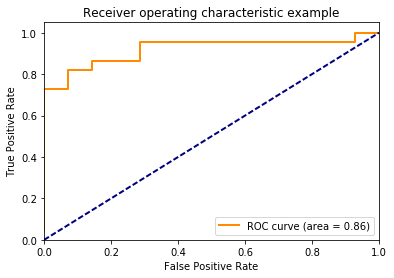

In [410]:
# instantiate a logistic regression model, and fit with training data
# we prefer have false positives than false negatives. So we want high recall for death=1
model = LogisticRegression()

param_grid = { 
    'C': [0.001, 0.01, 0.1,0.3,0.35,0.4,0.45, 0.5, 0.55, 0.6, 0.7, 1, 10, 100, 1000],
    'penalty' :['l1','l2'],
   # 'class_weight': [{0:.25, 1:.75}, {0:.5, 1:.5}, {0:.3, 1:.7}, {0:.4, 1:.6}   ]
}

optimalModel =findOptimalHParametersThoughtCV(model,X_train,y_train,param_grid)
predictions,probabilities= evaluateModel(optimalModel,X_test,y_test)
plotroc(y_test,predictions,probabilities)

# Decision Tree and Random Forest

In [433]:
# Create a random forest classifier. By convention, clf means 'classifier'
clf = RandomForestClassifier(random_state=1)

# Train the classifier to take the training features and learn how they relate
# to the training y (the species)
print('\n Random Forest Classifier: \n')

param_grid = { 
    'n_jobs' : [-1],
    'random_state' :[1],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [10 ,50 ,100 ,200],
    'n_estimators': [1 ,10 ,50 ,100 ,200]
   # 'class_weight': [{0:.25, 1:.75}, {0:.5, 1:.5}, {0:.3, 1:.7}, {0:.4, 1:.6}   ]
}

optimalModel =findOptimalHParametersThoughtCV(clf,X_train,y_train,param_grid)
predictions,probabilities= evaluateModel(optimalModel,X_test,y_test)
#plotroc(y_test,predictions,probabilities)




 Random Forest Classifier: 

Best parameters from grid search {'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 1}  , best score: 0.777777777778
Accuracy: 0.86  auc:  0.511904761905
Confusion Matrix
 [[ 1 41]
 [ 0 66]]
Classification report
              precision    recall  f1-score   support

          0       1.00      0.02      0.05        42
          1       0.62      1.00      0.76        66

avg / total       0.77      0.62      0.48       108

Matthew Correlation coefficient 0.121186832334


In [428]:
# Decision Tree graph

Index(['evd_ct', 'malaria', 'sex', 'age', 'quarantine', 'days_admitted',
       'referral_time', 'date_admis', 'temp_triage', 'pyrexia_triage',
       'anuria_triage', 'dyspnea_triage', 'disorientation_triage',
       'headache_triage', 'hiccups_triage', 'myalgia_triage', 'rash_triage',
       'dysphagia_triage', 'asthenia_triage', 'abdomnial_triage',
       'anorexia_triage', 'diarrhea_triage', 'diarrhea_score_triage',
       'vomiting_triage', 'hemorrhage_triage', 'orl_hemorrhage_triage',
       'conjonctivitis_triage', 'hemoptysis_triage', 'hematochezia_triage',
       'hematuria_triage', 'gynec_hemorrhage_triage', 'num_hemorrhages_triage',
       'mult_hemorrhage_triage', 'dehydration_triage', 'hepatomegaly_triage',
       'jaundice_triage', 'edema_triage', 'splenomegaly_triage'],
      dtype='object')


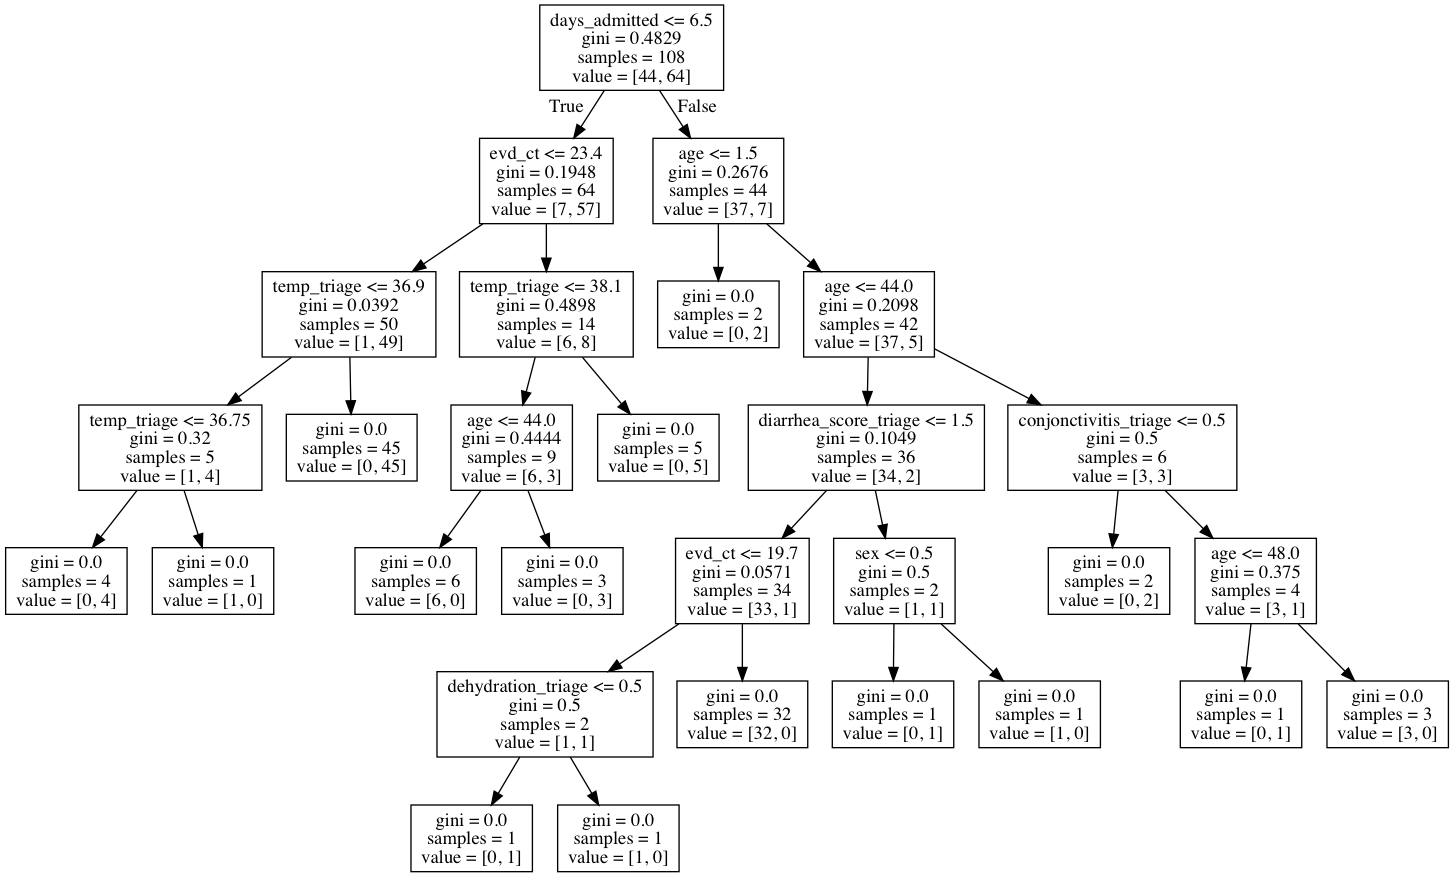

In [326]:
import pydotplus,os
from IPython.display import Image 
from sklearn import tree
clfdt1 = sklearn.tree.DecisionTreeClassifier()

dot_data = tree.export_graphviz(clfdt, out_file=None,feature_names=headers) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())  

In [292]:
%%R
library(ggplot2)

ggplot(y_pred) 
 # geom_bar(aes(evd_ct), stat = "bin") + 
 # geom_bar(aes(evd_ct, fill = factor(death)), stat = "bin", position = "dodge") +
 # scale_fill_manual(values=c("#DD3333", "#33CC66", "#eeee00"))


Error in ggplot(y_pred) : object 'y_pred' not found


/anaconda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in ggplot(y_pred) : object 'y_pred' not found

  warnings.warn(x, RRuntimeWarning)


# Feature selection through RFE and Randomized Lasso

In [1197]:
#rank all features, i.e continue the elimination until the last 3
rfe = RFE(model, 5) #recursive feature elimination, 
rfe = rfe.fit(X, ytrue)
# summarize the selection of the attributes
print(headers[rfe.support_ == True])
#print(rfe.support_)
#print(rfe.ranking_)

print('\nRandomized Lasso \n')
rlasso = RandomizedLasso(alpha=0.0001)
rlasso.fit(X, ytrue)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
                 headers), reverse=True))



Index(['disorientation_after', 'headache_after', 'abdominal_after',
       'diarrhea_score_after', 'hemorrhage_after'],
      dtype='object')

Randomized Lasso 

Features sorted by their score:
[(1.0, 'quarantine'), (1.0, 'evd_ct'), (1.0, 'disorientation_after'), (1.0, 'diarrhea_score_after'), (1.0, 'days_admitted'), (1.0, 'conjunctivitis_after'), (1.0, 'age'), (0.98999999999999999, 'referral_time'), (0.98499999999999999, 'abdominal_after'), (0.97999999999999998, 'myalgia_after'), (0.97499999999999998, 'hepatomegaly_after'), (0.96999999999999997, 'dehydration_after'), (0.95999999999999996, 'asthenia_after'), (0.95499999999999996, 'edema_after'), (0.94999999999999996, 'dyspnea_after'), (0.93500000000000005, 'malaria'), (0.93500000000000005, 'jaundice_after'), (0.92000000000000004, 'headache_after'), (0.91500000000000004, 'hiccups_after'), (0.91000000000000003, 'gyne_hemorrhage_after'), (0.91000000000000003, 'date_admis'), (0.90500000000000003, 'rash_after'), (0.90500000000000003, 'orl_h

# Feature selection through random forest

Feature ranking:
1. feature 5 days_admitted (0.180045)
2. feature 0 evd_ct (0.115369)
3. feature 3 age (0.074218)
4. feature 6 referral_time (0.038299)
5. feature 7 date_admis (0.036604)
6. feature 21 diarrhea_triage (0.035291)
7. feature 8 temp_triage (0.032870)
8. feature 26 conjonctivitis_triage (0.031760)
9. feature 20 anorexia_triage (0.031454)
10. feature 13 headache_triage (0.031329)
11. feature 17 dysphagia_triage (0.028879)
12. feature 4 quarantine (0.028399)
13. feature 23 vomiting_triage (0.026105)
14. feature 9 pyrexia_triage (0.024337)
15. feature 11 dyspnea_triage (0.024129)
16. feature 22 diarrhea_score_triage (0.023782)
17. feature 19 abdomnial_triage (0.023780)
18. feature 1 malaria (0.023664)
19. feature 2 sex (0.023403)
20. feature 18 asthenia_triage (0.022978)
21. feature 14 hiccups_triage (0.022890)
22. feature 12 disorientation_triage (0.022038)
23. feature 15 myalgia_triage (0.021844)
24. feature 33 dehydration_triage (0.016798)
25. feature 24 hemorrhage_triage (

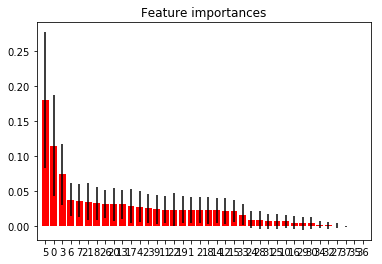

In [328]:
forest = ExtraTreesClassifier(n_estimators=250, #The number of trees in the forest
                              random_state=1)   #max_features: If “auto”, then max_features=sqrt(n_features).

forest.fit(X, ytrue)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], headers[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Other linear models

In [1289]:
import math
from sklearn.linear_model import RidgeCV


bestalpha=0
lastBestscore= math.inf
for k in range(5000):
    ridge = RidgeClassifier(alpha=k*.1)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    if k > 1 and RMSE < np.sqrt(metrics.mean_squared_error(y_test, y_pred)): #exit when RMSE don't decrease
        break
    RMSE= np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    if RMSE < lastBestscore:
        lastBestscore= RMSE
        #print('k: ',k, "Ridge: ",ridge.score(X_test,y_test), 'RMSE: ', RMSE)
        bestalpha= k*.1

print('Best alpha: ',bestalpha)

#Another Ridge Classifier, this time with 

#ridgecv = LogisticRegression(C=0.1, dual=False, penalty="l2")
ridgecv = RidgeClassifier(alpha=bestalpha)
scores = cross_val_score(ridgecv, X, ytrue, scoring='accuracy', cv=10)
print("Ridge 4Fold CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


######################################## CLASSS WEIGHT TO WORK ON
# reg = RidgeClassifier(class_weight={1: 0.001})

#############
 
lasso = Lasso(alpha=0.0005)
lasso.fit(X, ytrue)
print("Lasso: ",lasso.score(X, ytrue))
print("Lasso model: ", lasso.coef_)


#svc = svm.SVC(kernel='linear') #SVM overfits easily with few data and lots of features
svc= LinearSVC(C=0.01,tol=1e-05)
svc.fit(X_train, y_train)
print('svm score: ', svc.score(X_test,y_test))
print(confusion_matrix(y_test,svc.predict(X_test)),classification_report(y_test,svc.predict(X_test)))

 

Best alpha:  0.4
Ridge 4Fold CV Accuracy: 0.81 (+/- 0.16)
Lasso:  0.579071980754
Lasso model:  [-0.02377046  0.10063413  0.02360899  0.00388208  0.13203452 -0.0449265
 -0.02800152 -0.00281225 -0.01443728  0.0705753   0.27835202  0.07552628
  0.10109975 -0.14832967  0.10018681 -0.04042496 -0.26782518  0.0574477
 -0.03939296 -0.08694376 -0.05789553  0.06489026  0.00089441 -0.01253653
  0.0728544  -0.06455008  0.02501868  0.03343571  0.10269588  0.01720669
 -0.07630467 -0.         -0.10094036  0.08429501  0.18655963  0.          0.
 -0.33720373  0.00775986]
svm score:  0.888888888889
[[12  2]
 [ 2 20]]              precision    recall  f1-score   support

          0       0.86      0.86      0.86        14
          1       0.91      0.91      0.91        22

avg / total       0.89      0.89      0.89        36


 Random Forest Classifier: 

[[12  2]
 [ 5 17]]              precision    recall  f1-score   support

          0       0.71      0.86      0.77        14
          1       0.89

#  Neural net

In [434]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.75, random_state=1)
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
mlp = MLPClassifier(hidden_layer_sizes=(300,300,300))
mlp.fit(X_train,y_train)
predictions,probabilities= evaluateModel(mlp,X_test,y_test)
#plotroc(y_test,predictions,probabilities)

Accuracy: 0.77  auc:  0.754329004329
Confusion Matrix
 [[29 13]
 [12 54]]
Classification report
              precision    recall  f1-score   support

          0       0.71      0.69      0.70        42
          1       0.81      0.82      0.81        66

avg / total       0.77      0.77      0.77       108

Matthew Correlation coefficient 0.510967373154
